# Dataset ($\Omega_b, \Omega_{cdm}, H_0, \Omega_{K}, \theta_*$)  - CLASS

##### imports

In [5]:
from classy import Class, CosmoComputationError
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.stats import qmc # for LHS sampling
import time

##### Sobol

In [31]:
sampler17 = qmc.Sobol(d=4, scramble=True)
U1 = sampler17.random_base2(m=17) # 2^17 = 131072 samples
U2 = sampler17.random_base2(m=17) # another 131072 samples

Stacking & Scaling

In [32]:
X = np.vstack([U1, U2]) # we'll do more stacking later once we've gotten the CLASS outputs

param_mins = np.array([0.015, 0.05, 30/100, -0.2]) # Omg_b, Omg_cdm, h, Omg_k
param_maxs = np.array([0.03, 0.2, 120/100, 0.2])

X = qmc.scale(X, param_mins, param_maxs)
print(X.shape, type(X))

(262144, 4) <class 'numpy.ndarray'>


In [33]:
# check
print(X.min(axis=0))
print(X.max(axis=0))

[ 0.01500004  0.05000026  0.30000048 -0.19999923]
[0.02999995 0.19999991 1.19999705 0.19999862]


In [34]:
N = X.shape[0]

##### CLASS calling & dataset gen

In [35]:
timestamp = time.strftime("%Y%m%d_%H%M%S")
filename = f"theta_star_dataset_{timestamp}.csv"

# ---- FIXED parameters PLANCK 2018 ----------------------------------------------
tau = 0.054
n_s = 0.965
A_s = 2.0968e-9  

# ---- LHS/Sobol sample (your 4 parameters) ----------------------------------------
# X is shape (N, 4):
# X[:,0] = Omega_b
# X[:,1] = Omega_cdm
# X[:,2] = h
# X[:,3] = Omega_k

rejected_points= []
param_names = ["Omega_b", "Omega_cdm", "h", "Omega_k"]


N = X.shape[0]
print("Total samples to process:", N)
rows = [] # accepted


# Create CLASS instance.                               ### faster outside
cosmo = Class()

for i in range(N):
    Omega_b, Omega_cdm, h, Omega_k = X[i]

    params = {
    'output': '',        # faster version
    'Omega_b': Omega_b,
    'Omega_cdm': Omega_cdm,
    'h': h,
    'Omega_k': Omega_k,
    'A_s': A_s,
    'n_s': n_s,
    'tau_reio': tau,}

    cosmo.set(params)

    try:
        cosmo.compute()
    
        # Extract theta_star (CLASS outputs 100 * theta_s)                                ### inside
        derived = cosmo.get_current_derived_parameters(['100*theta_s'])
        theta100 = derived['100*theta_s']
        rows.append([Omega_b, Omega_cdm, h, Omega_k, theta100])

    except CosmoComputationError:
        rejected_points.append([params[p] for p in param_names])
        continue

    # clean memory
    cosmo.struct_cleanup()                                ### eoutside
    cosmo.empty()

    # progress
    print(f"{i+1}/{N}   ({(i+1)/N*100:.2f}%)", end='\r')

print("\nDone!")

# ---- Save to CSV ------------------------------------------------------------
with open(filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Omega_b", "Omega_cdm", "h", "Omega_k", "theta_star"])
    writer.writerows(rows)
 
print(f"Saved to {filename}")


filename2 = f"REJECTED_points_{timestamp}.csv"

with open(filename2, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Omega_b", "Omega_cdm", "h", "Omega_k", "theta_star"])
    writer.writerows(rejected_points)

Total samples to process: 262144


KeyboardInterrupt: 

##### results

In [13]:
filename = 'REJECTED_points_20251216_021501.csv'  # Replace with your CSV file path

with open(filename, 'r', newline='') as f:
    reader = csv.reader(f)
    row_count = sum(1 for row in reader)

filename2 = 'theta_star_dataset_20251216_021501.csv'  # Replace with your CSV file path

with open(filename2, 'r', newline='') as f:
    reader = csv.reader(f)
    row_count2 = sum(1 for row in reader)

print(f"Number of rows REJECTED: {row_count}")
print(f"Number of rows accepted: {row_count2}")
print(f"Rejected + accepted: {row_count + row_count2}")
print(f'N: {N}')


Number of rows REJECTED: 92355
Number of rows accepted: 169791
Rejected + accepted: 262146
N: 262144


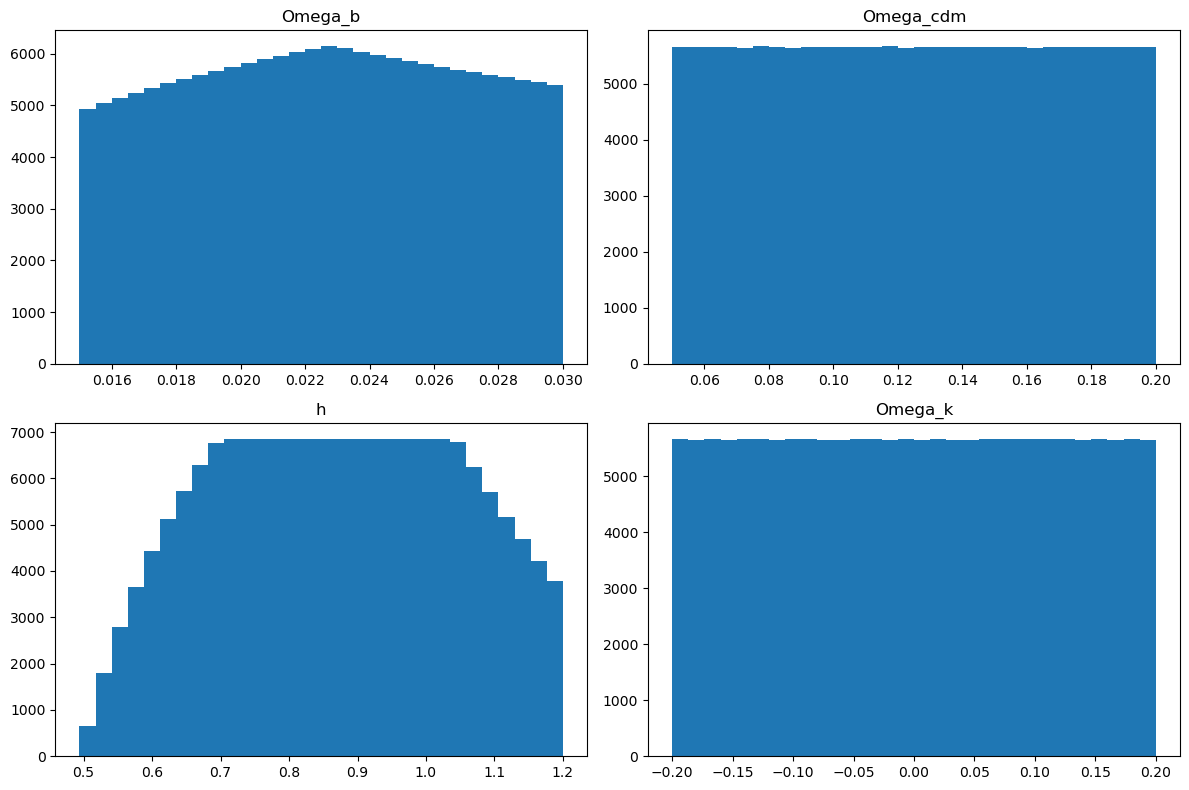

In [6]:
df = pd.read_csv("accepted_n18.csv")

params = ["Omega_b", "Omega_cdm", "h", "Omega_k"]

plt.figure(figsize=(12, 8))
for i, p in enumerate(params):
    plt.subplot(2, 2, i+1)
    plt.hist(df[p], bins=30)
    plt.title(p)
plt.tight_layout()
plt.show()

-------

In [7]:
x_bad = [0.01795145, 0.17197511, 0.96386311, -0.04580834]

tau = 0.054
n_s = 0.965
A_s = 2.0968e-9 

print("x_bad:", x_bad)
cosmo = Class()
params = {
'output': '',        # faster version
'Omega_b': x_bad[0],
'Omega_cdm': x_bad[1],
'h': x_bad[2],
'Omega_k': x_bad[3],
'A_s': A_s,
'n_s': n_s,
'tau_reio': tau,}
cosmo.set(params)
try:
    cosmo.compute()

    # Extract theta_star (CLASS outputs 100 * theta_s)                                ### inside
    derived = cosmo.get_current_derived_parameters(['100*theta_s'])
    theta100 = derived['100*theta_s']
    theta_star = theta100 / 100.0
    print("Computation successful for x_bad:", theta_star)
except CosmoComputationError:
    print("Computation error for x_bad")

x_bad: [0.01795145, 0.17197511, 0.96386311, -0.04580834]
Computation successful for x_bad: 0.012981735927109972


In [8]:
# df at inderx 84954
df.iloc[84954]

Omega_b       0.017951
Omega_cdm     0.171975
h             0.963863
Omega_k      -0.045808
theta_star         NaN
Name: 84954, dtype: float64

In [9]:
df.at[84954, "theta_star"] = 0.012981735927109972
# 3. Save back to CSV
#df.to_csv("MOD_accepted_n18.csv", index=False)
df.to_csv("DEF_accepted_n18.csv", index=False)

--------

In [1]:
import pandas as pd

In [21]:
df = pd.read_csv("MOD_accepted_n18.csv") 
df.head()

,Omega_b,Omega_cdm,h,Omega_k,theta_star
0,0.026748,0.160473,1.037008,-0.006475,0.011763
1,0.025353,0.068666,0.586559,0.123092,0.005628
2,0.016434,0.189707,0.857403,-0.135443,0.015651
3,0.017468,0.084910,1.148521,-0.173052,0.030266
4,0.029657,0.111781,0.969573,-0.094208,0.014594


In [ ]:
df_selected = df[
    (df["Omega_cdm"] > 0.08) &
    (df["Omega_k"] > -0.1)   #(df["Omega_k"].between(2.0, 5.0))
]
df_selected.to_csv("MOD_accepted_n18.csv", index=False)


In [25]:
print(f"Original rows: {len(df)}")
print(f"Accepted rows: {len(df_selected)}")

Original rows: 169790
Accepted rows: 101863


In [ ]:
# df_selected2 = df[
#     (df.iloc[:, 3].between(-0.1, 0.2)) &   # column 3 between 2.0 and 5.0
#     (df.iloc[:, 1] > 0.08)                 # column 4 greater than 0.1
# ]

-------------

the good one

In [11]:
df2 = pd.read_csv("DEF_accepted_n18.csv")
df2.head()

,Omega_b,Omega_cdm,h,Omega_k,theta_star
0,0.026748,0.160473,1.037008,-0.006475,0.011763
1,0.025353,0.068666,0.586559,0.123092,0.005628
2,0.016434,0.189707,0.857403,-0.135443,0.015651
3,0.017468,0.084910,1.148521,-0.173052,0.030266
4,0.029657,0.111781,0.969573,-0.094208,0.014594


In [13]:
df_selected2 = df2[df2["Omega_cdm"] > 0.08]
df_selected2.to_csv("DEF_-02+02_accepted_n18.csv", index=False)

-------

In [44]:
df_theta100 = df.copy()
df_theta100['theta_star'] = df_theta100['theta_star']*100
df.head(), df_theta100.head()

(    Omega_b  Omega_cdm         h   Omega_k  theta_star
 0  0.026748   0.160473  1.037008 -0.006475    0.011763
 1  0.025353   0.068666  0.586559  0.123092    0.005628
 2  0.016434   0.189707  0.857403 -0.135443    0.015651
 3  0.017468   0.084910  1.148521 -0.173052    0.030266
 4  0.029657   0.111781  0.969573 -0.094208    0.014594,
     Omega_b  Omega_cdm         h   Omega_k  theta_star
 0  0.026748   0.160473  1.037008 -0.006475    1.176314
 1  0.025353   0.068666  0.586559  0.123092    0.562764
 2  0.016434   0.189707  0.857403 -0.135443    1.565139
 3  0.017468   0.084910  1.148521 -0.173052    3.026590
 4  0.029657   0.111781  0.969573 -0.094208    1.459433)

In [45]:
df_theta100.to_csv("MODD_th100_accepted_n18.csv", index=False)